# Tutorial: Tabular regression model with fastai2



Tabular modelling takes data in the form of a table (like a spreadsheet or CSV--comma separated values). The objective is to predict the value in one or more columns, based on the values in the other columns.

A regression model is one which attempts to predict one or more numeric quantities, such as a temperature or a location.

In this tutorial, we'll be looking at the dataset from the Rossmann's Kaggle competition. The premise is that we're given the sales data and information of their stores for the past few years. We need to make a model that can predict the number of sales that will be made in the future. This tutorial is based on selected contents from these two notebooks:
* https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb
* https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Tabular%20Notebooks/02_Regression_and_Permutation_Importance.ipynb

This problem can then be expanded to predict the variables of interest in our dataset of re-entry uncertainties!

## Setup the GPU

Before starting, you will need to set colab to use the GPU:
* Go to Edit > Notebook settings or Runtime > Change runtime type and select GPU as Hardware accelerator.
* https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d

## Install Fastai2 library

The fastai2 library is not pre-installed in colab so we first need to pip install it. Using "!" at the beginning of a cell in a Jupyter notebook runs a shell command inside the notebook, and installs the library directly to the colab virtual machine. You only need to rerun this when restarting the kernel.

In [0]:
!pip install -q fastai2

     |████████████████████████████████| 194kB 9.4MB/s 


In fastai2, all the modules related to tabular learning can be found under *fastai.tabular.all*.


In [0]:
from fastai2.tabular.all import *

We'll need to do some tabular data processing and querying, so we'll want to use the Pandas library. Finally, we'll also need numpy, since that's the main numeric programming library that Pandas rely on.


In [0]:
import numpy as np
import pandas as pd

## Download & Access Data

Rossmann's Kaggle competition was a business sales prediction competition for $35,000 dollars to the winners.

The premise is that we're given the sales data and information of their stores for the past few years. We need to make a model that can predict the number of sales that will be made in the future.

For this tutorial we will download a clean engineered dataset

In [0]:
from fastai2.data.all import *

In [0]:
download_url('https://aida.ii.uam.es/data/stardust_ltw/train_rossman', dest='tutorial_data')

In [0]:
df = pd.read_pickle('tutorial_data')

In [0]:
df.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State,file,week,trend,file_DE,week_DE,trend_DE,Date_DE,...,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_PressurehPa,Mean_Sea_Level_PressurehPa,Min_Sea_Level_PressurehPa,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees,StateName,CompetitionOpenSince,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Since,Promo2Days,Promo2Weeks,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,0,1,5,2015-07-31,5263,555,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,a,1270.0,9,2008,0,1,1900,NaN,HE,Rossmann_DE_HE,2015-08-02 - 2015-08-08,85,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,16,8,9,6,3,98,54,18,1021,1018,1015,31.0,15.0,10.0,24,11,NaN,0.0,1.0,Fog,13,Hessen,2008-09-15,2510,24,1900-01-01,0,0,0,0,57,0,0,0,5.0,0.0,5.0,7.0,0.0,5.0
1,1,2,5,2015-07-31,6064,625,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",TH,Rossmann_DE_TH,2015-08-02 - 2015-08-08,80,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,13,7,9,6,3,100,62,25,1021,1019,1017,10.0,10.0,10.0,14,11,NaN,0.0,4.0,Fog,309,Thueringen,2007-11-15,2815,24,2010-03-29,1950,25,0,0,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
2,2,3,5,2015-07-31,8314,821,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",NW,Rossmann_DE_NW,2015-08-02 - 2015-08-08,86,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,13,6,10,7,4,100,61,24,1022,1019,1017,31.0,14.0,10.0,14,5,NaN,0.0,2.0,Fog,354,NordrheinWestfalen,2006-12-15,3150,24,2011-04-04,1579,25,0,0,57,0,0,0,5.0,0.0,5.0,5.0,0.0,5.0
3,3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,c,c,620.0,9,2009,0,1,1900,NaN,BE,Rossmann_DE_BE,2015-08-02 - 2015-08-08,74,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,14,9,9,7,4,94,61,30,1019,1017,1014,10.0,10.0,10.0,23,16,NaN,0.0,6.0,NaN,282,Berlin,2009-09-15,2145,24,1900-01-01,0,0,0,0,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
4,4,5,5,2015-07-31,4822,559,1,1,False,1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800,a,a,29910.0,4,2015,0,1,1900,NaN,SN,Rossmann_DE_SN,2015-08-02 - 2015-08-08,82,Rossmann_DE,2015-08-02 - 2015-08-08,83,2015-08-02,...,15,10,8,6,5,82,55,26,1020,1018,1016,10.0,10.0,10.0,14,11,NaN,0.0,4.0,NaN,290,Sachsen,2015-04-15,107,3,1900-01-01,0,0,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0


## Preprocess Data

In [0]:
dep_var = 'Sales'

When doing Regression with these large numbers, we often use the log of these values for our y's. Let's transform them real quick:

In [0]:
df[dep_var] = np.log(df[dep_var])

In [0]:
cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday']

Here is the code necessary to create a tabular dataloaders from a dataframe in `fastai2`:

In [0]:
dls = TabularDataLoaders.from_df(df=df, 
                           procs=[FillMissing(add_col=False), Normalize], 
                           cont_names=cont_vars, 
                           y_names=dep_var, 
                           y_block=RegressionBlock(), 
                           valid_pct=0.2,
                           bs=1024)

When you train a model, you must always have both a training set and a validation set, and must measure the accuracy of your model only on the validation set. If you train for too long, with not enough data, you will see the accuracy of your model start to get worse; this is called overfitting. fastai defaults valid_pct to 0.2, so even if you forget, fastai will create a validation set for you!



In [0]:
dls.train.n, dls.valid.n

(675471, 168867)

As you see, we had to tell fastai which columns are categorical (that is, contain values that are one of a discrete set of choices, such as occupation) and which are continuous (that is, contain a number that represents a quantity, such as age), using the arguments `cat_names` and `cont_names` respectively. Since the aim of this tutorial is to be transfered to the re-entry problem, which only contains continuos variables, we will only add the `cont_names` from the dataset.

In [0]:
dls.cont_names

(#14) ['CompetitionDistance','Max_TemperatureC','Mean_TemperatureC','Min_TemperatureC','Max_Humidity','Mean_Humidity','Min_Humidity','Max_Wind_SpeedKm_h','Mean_Wind_SpeedKm_h','CloudCover'...]

The other important piece of information that we have to tell fastai is how to get the dependent variables from the dataset (the `ys`). For that purpose you use the argument `y_names`. The argument `y_block` specifies the type of ML task we are interestied in (in this case, regression).

In [0]:
dls.ys

,Sales
172725,8.838697
432815,8.569216
564031,8.048149
423394,8.480944
437957,8.828787
...,...
525165,8.710620
524584,8.437717
590892,8.401109
245100,8.508354


A neural network definitely cares about normalization of the input data. Therefore, we add the Normalize *processor* when we build our `TabularDataLoaders`. A `processor` transform the data auomatically for training.

In [0]:
dls.procs

Pipeline: FillMissing -> RegressionSetup -> Normalize

In deep learning, we don't feed the model one item at a time but several of them (what we call a *mini-batch*, or just a *batch*). To group them in a big array (usually called a tensor) that is going to go through our model, they all need to be of the same size. DataLoader is a class that provides batches of a few items at a time to the GPU. When you loop through a DataLoader fastai will give you 64 (default batch size `bs`) items at a time, all stacked up into a single tensor. Tabular models and data don't generally require much GPU RAM, so we can use larger batch sizes. We can take a look at a few of those items by calling the `show_batch` method on a DataLoader. Note that the `DataLoaders` object `dls` includes validation and training DataLoaders. 

In [0]:
dls.valid.show_batch()

,CompetitionDistance,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Sales
0,100.0,18.0,9.0,-1.0,94.0,65.0,23.999998,14.0,5.0,6.0,67.0,63.0,75.0,-17.0,8.956738
1,180.0,22.0,14.0,7.0,87.0,53.0,19.000002,16.0,8.0,6.0,62.0,67.0,7.0,-6.0,8.793916
2,100.0,22.0,18.0,12.0,95.0,65.0,29.000000,21.0,13.0,5.0,76.0,68.0,2.0,0.0,8.500657
3,840.0,7.0,2.0,-2.0,100.0,89.0,58.000000,14.0,6.0,4.0,73.0,62.0,4.0,-2.0,8.893161
4,9430.0,1.0,-1.0,-3.0,86.0,71.0,54.000000,29.0,16.0,5.0,51.0,51.0,51.0,-36.0,8.661813
5,130.0,6.0,0.0,-5.0,74.0,50.0,22.000000,27.0,14.0,6.0,57.0,57.0,85.0,-2.0,8.747352
6,8240.0,24.0,19.0,15.0,94.0,61.0,29.000000,34.0,18.0,7.0,66.0,83.0,53.0,0.0,9.275847
7,1090.0,21.0,18.0,14.0,95.0,81.0,47.000000,29.0,16.0,5.0,61.0,60.0,23.0,-6.0,8.522181
8,6560.0,19.0,16.0,11.0,88.0,67.0,39.000000,32.0,18.0,6.0,61.0,60.0,8.0,-20.0,9.257415
9,4260.0,18.0,11.0,4.0,81.0,62.0,27.000000,32.0,11.0,6.0,79.0,75.0,83.0,-9.0,8.621553


## Training a Model

First we set up a `tabular_learner`, and what data we want to train it on.

In [0]:
y_range = torch.tensor([0, np.max(df[dep_var])*1.2])

In [0]:
learn = tabular_learner(dls, loss_func=MSELossFlat())

In order to define how well a model does on a single prediction, we need to define a loss function, which determines how we score a prediction as good or bad. We set the loss function to MSE, an standard in regression problems.

In [0]:
learn.loss_func

FlattenedLoss of MSELoss()

We can take a look at the default architecture created for our tabular regression model. You can change the number of size of the layers when creating the learner.

In [0]:
learn.summary()

TabularModel (Input shape: ['1024 x 0', '1024 x 14'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          1024 x 14            28         True      
________________________________________________________________
BatchNorm1d          1024 x 14            28         True      
________________________________________________________________
Linear               1024 x 200           2,800      True      
________________________________________________________________
ReLU                 1024 x 200           0          False     
________________________________________________________________
BatchNorm1d          1024 x 200           400        True      
________________________________________________________________
Linear               1024 x 100           20,000     True      
________________________________________________________________
ReLU                 1024 x 100           0          False     
____________________________________________

To fit the architecture to the data, we use `fit_one_cycle`, the most commonly used method for training fastai models from scratch (i.e. without transfer learning):

epoch,train_loss,valid_loss,time
0,0.266944,0.208318,00:09
1,0.192836,0.193657,00:09
2,0.173657,0.167535,00:09
3,0.170766,0.157776,00:09
4,0.163161,0.156086,00:09


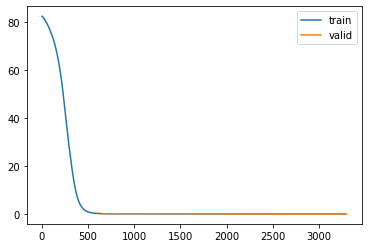

In [0]:
learn.fit_one_cycle(n_epoch=5, lr_max=1e-3)
learn.recorder.plot_loss()

Deciding how to change our parameters based on the values of the gradients is an important part of the deep learning process. Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the learning rate (lr). The learning rate is often a number between 0.001 and 0.1, although it could be anything. Often, people select a learning rate just by trying a few, and finding which results in the best model after training (we'll show you more about this in tomorrow's project). If you pick a learning rate that's too low, it can mean having to do a lot of steps. But picking a learning rate that's too high is even worse--it can actually result in the loss getting worse.

### Inference on a test set

Now that we have a model, we want to make our predictions on a *test set*. A test set cannot be used to improve the model; it can only be used to evaluate the model at the very end of our efforts.

In [0]:
download_url('https://aida.ii.uam.es/data/stardust_ltw/test_tutorial_tabular_regression', dest='tutorial_data_test')

In [0]:
test_df = pd.read_pickle('tutorial_data_test')

Now we generate our test dataloader `test_dl` from our test dataframe `test_df`

In [0]:
dl = learn.dls.test_dl(test_df)

We need to tell the Learner to return the predictions for the test set we added

In [0]:
raw_test_preds = learn.get_preds(dl=dl)
raw_test_preds

(tensor([[8.5598],
         [8.6992],
         [8.5929],
         ...,
         [8.7424],
         [8.7890],
         [8.7494]]), None)

You'll notice [0] contains our predictions, and [1] contains any labels (if we had any, in this case not because it's a test set)

In [0]:
raw_test_preds

(tensor([[8.5598],
         [8.6992],
         [8.5929],
         ...,
         [8.7424],
         [8.7890],
         [8.7494]]), None)

We need to undo our log transform

In [0]:
test_preds = np.exp(raw_test_preds[0]).numpy().T[0]
test_preds

array([5217.519, 5998.241, 5393.089, ..., 6263.101, 6561.727, 6306.651],
      dtype=float32)

Finally, we can save them into a CSV file, if needed

In [0]:
pd.DataFrame(test_preds).to_csv('results.csv')

## Understanding the results

### Baseline

A baseline is a simple model which you are confident should perform reasonably well. It should be very simple to implement, and very easy to test, so that you can then test each of your improved ideas, and make sure they are always better than your baseline. Without starting with a sensible baseline, it is very difficult to know whether your super-fancy models are actually any good.

For this problem, the easiest baseline that you can think of is a model that always predicts the average value of the dependent variable.

In [0]:
y_train_avg = dls.train.y.mean()
y_train_avg

8.757654425290276

In [0]:
F.mse_loss(tensor(dls.valid.y.values), tensor(y_train_avg))

Using a target size (torch.Size([])) that is different to the input size (torch.Size([168867])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


tensor(0.1810)

Our model is doing better than the baseline (the final validation loss is lower)

### Show top losses

Show the items where the model performs the worst (and best) to try and understanding what the model is deficient in, and successful at.

In [0]:
def show_top_losses(tab_learner, k=None, largest=True):
  interp = Interpretation.from_learner(tab_learner)
  top_losses = interp.top_losses(k, largest)
  to_top_losses = tab_learner.dls.valid.dataset.iloc[top_losses.indices]
  to_top_losses.show()

In [0]:
show_top_losses(learn, k=10, largest=True)

,CompetitionDistance,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Sales
168162,18540.0,1.000000,-1.0,-3.0,100.0,87.0,75.0,32.0,16.0,6.0,76.0,72.0,36.0,-62.0,4.820282
779886,21370.0,-1.999999,-3.0,-3.0,100.0,86.0,74.0,37.0,29.0,6.0,48.0,54.0,68.0,-19.0,5.655992
274995,290.0,22.000000,19.0,16.0,98.0,89.0,70.0,6.0,3.0,8.0,63.0,58.0,103.0,-13.0,6.612041
572972,290.0,17.000000,10.0,4.0,100.0,77.0,43.0,29.0,11.0,6.0,78.0,63.0,16.0,-12.0,6.513230
685811,290.0,22.000000,17.0,11.0,88.0,66.0,39.0,26.0,14.0,3.0,52.0,59.0,33.0,-103.0,6.603944
806013,1080.0,1.000000,-1.0,-4.0,69.0,57.0,35.0,26.0,16.0,7.0,66.0,58.0,41.0,-46.0,6.226537
625093,14600.0,19.000000,17.0,14.0,100.0,84.0,63.0,24.0,18.0,6.0,63.0,57.0,88.0,-38.0,6.800170
84475,1180.0,12.000000,8.0,3.0,100.0,74.0,41.0,23.0,11.0,3.0,62.0,73.0,0.0,0.0,10.557998
618894,290.0,23.000000,17.0,12.0,94.0,67.0,37.0,29.0,14.0,5.0,49.0,57.0,103.0,-33.0,6.891626
398565,290.0,19.000000,13.0,7.0,100.0,77.0,55.0,13.0,6.0,5.0,72.0,74.0,5.0,-5.0,6.595781


In [0]:
show_top_losses(learn, k=10, largest=False)

,CompetitionDistance,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Sales
503790,6400.0,8.000000,7.000000,6.000000,100.0,82.0,57.0,26.0,13.0,6.0,72.0,67.0,3.0,-104.0,8.779711
96667,110.0,14.000000,8.000000,3.000000,76.0,47.0,18.0,26.0,14.0,2.0,61.0,65.0,12.0,-13.0,8.856518
807679,850.0,-1.999999,-5.999999,-9.000001,100.0,88.0,69.0,24.0,13.0,6.0,45.0,51.0,34.0,-48.0,8.735043
741425,8080.0,14.000000,11.000000,8.000000,93.0,78.0,59.0,14.0,11.0,6.0,54.0,52.0,21.0,-9.0,8.962007
469157,460.0,9.000000,6.000000,3.000000,94.0,66.0,32.0,26.0,18.0,7.0,74.0,68.0,40.0,-67.0,8.522579
673595,180.0,23.000000,20.000000,17.000000,94.0,73.0,46.0,18.0,6.0,5.0,75.0,58.0,46.0,-90.0,8.888619
18527,1590.0,22.000000,19.000000,16.000000,94.0,73.0,50.0,26.0,11.0,6.0,68.0,74.0,39.0,0.0,8.875007
246287,70.0,12.000000,9.000000,6.000000,100.0,87.0,66.0,19.0,10.0,5.0,82.0,72.0,24.0,-59.0,8.804475
550453,7660.0,5.000000,3.000000,1.000000,100.0,92.0,86.0,11.0,5.0,7.0,67.0,71.0,12.0,-42.0,8.596928
570741,10800.0,22.000000,18.000000,14.000000,94.0,74.0,54.0,40.0,23.0,6.0,61.0,60.0,19.0,-10.0,8.874868


### Interpreting the predictions with SHAP

[SHAP](https://github.com/slundberg/shap) is a library for interpreting prediction models (of any kind), and we can use it to help us with tabular data too. SHAP measures the impact of variables taking into account the interaction with other variables. Shapley values calculate the importance of a feature by comparing what a model predicts with and without the feature. The library `FastSHAP` brings in part of the SHAP library into fastai2 and make it compatible.



In [0]:
!pip install -q fastshap

     |████████████████████████████████| 276kB 10.4MB/s 


First let's import the interpretability module:


In [0]:
from fastshap.interp import *

And now we'll make a ShapInterpretation object. It expects your Learner along with some test data to look at and any keywords that SHAP can use. If you don't pass anything in it will use a subset of your validation data:

In [0]:
learn.dl.vocab = learn.dl.y_names # This is only needed for regression problems
exp = ShapInterpretation(learn)

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below (summary plot) sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low).

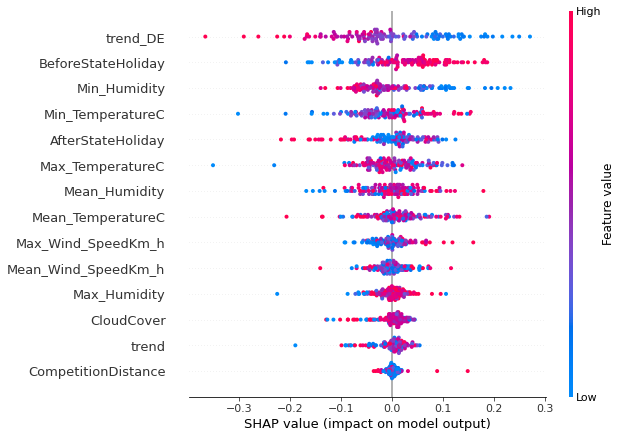

In [0]:
exp.summary_plot()

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in predicted dependent variable as 'Mean_TemperatureC' changes. Vertical dispersion at a single value of 'Mean_TemperatureC' represents interaction effects with other features. To help reveal these interactions `dependence_plot` automatically selects another feature for coloring. You can change the interaction variable to visualize trhough the argument `interaction_index`

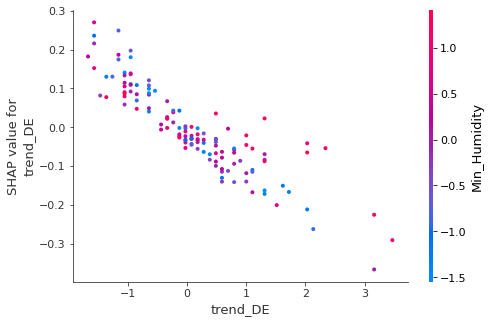

In [0]:
exp.dependence_plot('trend_DE')